In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
from unet.model import unet
from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json


In [56]:
mbsize = 256
report_freq=s.report_freq
weight_path=s.weights_path
lr=s.learning_rate
save_freq = s.save_freq
time_namer = time.strftime("%y%m%d%H%M%S")
load_specific = False
parent_name = None
epochs = s.epochs

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_shape=(3,32,32)
out_shape=(s.classes,32,32)

weight_path_ending=os.path.join(weight_path,time_namer+"_"+s.weights_name)
print("NETWORK PATH:", weight_path_ending)

loss_path_ending = os.path.join(weight_path, time_namer + "_" + s.loss_name)
model_description_path_ending = os.path.join(weight_path,s.model_description_name)
#using the matlab formula: 0.2989 * R + 0.5870 * G + 0.1140 * B 

#transformGray = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#transform = transforms.Compose([transforms.ToTensor()])#,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mbsize,
                                      shuffle=True, num_workers=2)

NETWORK PATH: weights\190730155447_unet.pth
Files already downloaded and verified


In [57]:
#print("dataset_type",dataset_type)
#dataloader
#trainloader=torch.utils.data.DataLoader(dataset,batch_size=mbsize,shuffle=True, num_workers=1)

#define model
UNet=unet().to(device)
#load weights
if not parent_name is None or load_specific:
    try:
        if load_specific:
            UNet.load_state_dict(torch.load(weight_path_ending))
        else:
            UNet.load_state_dict(torch.load(parent_path_ending))
        print("Loaded weights from", parent_path_ending)
    except FileNotFoundError:
        print("Unable to find weight path "+ parent_path_ending + ". Initializing new weights.")
        # weights already initialized in unet.__init__()
else:
    print("No parent network specified. Initialized new weights.")
    #TODO: fix this 
    '''
    # change model overview list:
    if not time_namer in model_dict.keys():
        model_dict[time_namer] = {
            "data_set_path": data_path,
            "loaded_weights": parent_name,
            "epochs": e,
            "batch_size": mbsize,
            "scale": s.scale,
            "crop": s.crop_size,
            "batch_normalization": batch_norm,
            "loss_normalization": loss_norm,
            "lr": lr,
            "betas": s.betas
        }
    else:
        model_dict[time_namer]["epochs"] = e  # only epochs change when model is already mentioned in dict
    with open(model_description_path_ending, "w") as file:
        json.dump(model_dict, file, sort_keys=True, indent=4)'''
UNet.train()
#optimizer
optimizer=optim.Adam(UNet.parameters(),lr=lr,betas=s.betas)
criterion = nn.MSELoss().to(device)

loss_hist=[]

# initialize model dict
try:
    with open(model_description_path_ending, "r") as file:
        model_dict = json.load(file)
except FileNotFoundError:
    model_dict = {}



No parent network specified. Initialized new weights.


In [58]:
#convert to black and white image using following weights
gray = torch.tensor([0.2989 ,0.5870, 0.1140 ])[:,None,None].float()
# run over epochs
for e in (range(epochs) if not s.infinite_loop else count()):
    #load batches
    for i,(image,c) in enumerate(trainloader):
        #clear gradients
        optimizer.zero_grad()
        #convert to grayscale image
        
        #using the matlab formula: 0.2989 * R + 0.5870 * G + 0.1140 * B and load data to gpu
        X=(image.clone()*gray).sum(1).to(device).view(-1,1,*in_shape[1:])
        image=image.float().to(device)
        #generate colorized version with unet
        unet_col=UNet(X)
        #calculate loss
        loss=criterion(unet_col, image)
        #backpropagation
        loss.backward()
        loss_hist.append([e,i,loss.item()])
        optimizer.step()
        #report loss
        if (i+len(trainloader)*e)%report_freq==report_freq-1:
            print('Epoch %i, batch %i: loss=%.2e'%(e+1,i+1,
            loss.item()))#np.convolve(loss_hist, np.ones((s.batch_size,))/s.batch_size, mode='valid')))
        if s.save_weights and (i+len(trainloader)*e)%save_freq==save_freq-1:
            #save parameters
            try:
                torch.save(UNet.state_dict(),weight_path_ending)
            except FileNotFoundError:
                os.makedirs(weight_path)
                torch.save(UNet.state_dict(),weight_path_ending)
            print("saved parameters")
            if s.save_loss:
                #save loss history to file
                try:
                    f=open(loss_path_ending,'a')
                    np.savetxt(f,loss_hist,'%e')
                    f.close()
                except FileNotFoundError:
                    os.makedirs(s.loss_path)
                    np.savetxt(loss_path_ending,loss_hist,'%e')
                loss_hist=[]


Epoch 1, batch 10: loss=3.54e-02
Epoch 1, batch 20: loss=1.59e-02
Epoch 1, batch 30: loss=9.95e-03
Epoch 1, batch 40: loss=7.96e-03


KeyboardInterrupt: 

In [4]:
un=unet()
un.state_dict()

OrderedDict([('input.double_conv.0.weight',
              tensor([[[[-8.6663e-02,  5.9201e-02,  6.5406e-02],
                        [-4.5270e-02,  2.7067e-02,  1.5981e-02],
                        [-2.2624e-02,  2.2830e-03, -1.1621e-02]]],
              
              
                      [[[ 7.4971e-03, -4.0665e-02, -9.5702e-02],
                        [-1.0258e-01,  7.0541e-02,  2.7668e-02],
                        [ 5.5302e-02, -2.6427e-02,  1.0026e-01]]],
              
              
                      [[[ 6.4967e-02,  7.4669e-02,  1.0442e-01],
                        [ 2.1975e-02,  4.3031e-02, -5.7790e-02],
                        [-6.6185e-03, -2.0047e-02, -2.6862e-02]]],
              
              
                      [[[-1.1918e-02, -4.8519e-02,  1.1585e-02],
                        [ 3.9195e-02,  5.7437e-02,  9.6924e-02],
                        [-4.8877e-02, -2.1914e-02, -2.6921e-02]]],
              
              
                      [[[ 3.7172e-02,  7.0789e-0

In [7]:
torch.save(un.state_dict(),'weights/test.pth')

In [8]:
un.load_state_dict(torch.load('weights/test.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
tt2=trainloader.dataset.data[:6]
tt2

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [23]:
torch.from_numpy(tt2).shape

torch.Size([6, 32, 32, 3])

In [28]:
tttt2=(torch.from_numpy(tt2)*torch.tensor([0.2989 ,0.5870, 0.1140 ])[None,None,None,:].byte()).sum(0)
tttt2.shape

torch.Size([6, 32, 32])

In [76]:
torch.tensor([1,2,3])[None,None,:].shape

torch.Size([1, 1, 3])

In [4]:
tt=trainloader.dataset.data[0]
import matplotlib.pyplot as plt

In [49]:
tt.shape

(32, 32, 3)

In [36]:
ttt=transformGray(tt)

In [50]:
type(tt)

numpy.ndarray

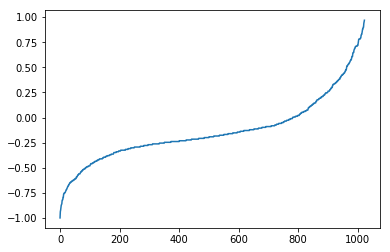

In [43]:
plt.plot(sorted(ttt.flatten()))

In [62]:
transforms.T

(32, 32, 3)

In [29]:
plt.imshow(transforms.ToPILImage()(tttt2[0]),cmap='gray')

TypeError: Input type int64 is not supported

In [31]:
tttt2[0].max()

tensor(0)

In [33]:
a=torch.arange(150).view(2,3,5,5)
a

tensor([[[[  0,   1,   2,   3,   4],
          [  5,   6,   7,   8,   9],
          [ 10,  11,  12,  13,  14],
          [ 15,  16,  17,  18,  19],
          [ 20,  21,  22,  23,  24]],

         [[ 25,  26,  27,  28,  29],
          [ 30,  31,  32,  33,  34],
          [ 35,  36,  37,  38,  39],
          [ 40,  41,  42,  43,  44],
          [ 45,  46,  47,  48,  49]],

         [[ 50,  51,  52,  53,  54],
          [ 55,  56,  57,  58,  59],
          [ 60,  61,  62,  63,  64],
          [ 65,  66,  67,  68,  69],
          [ 70,  71,  72,  73,  74]]],


        [[[ 75,  76,  77,  78,  79],
          [ 80,  81,  82,  83,  84],
          [ 85,  86,  87,  88,  89],
          [ 90,  91,  92,  93,  94],
          [ 95,  96,  97,  98,  99]],

         [[100, 101, 102, 103, 104],
          [105, 106, 107, 108, 109],
          [110, 111, 112, 113, 114],
          [115, 116, 117, 118, 119],
          [120, 121, 122, 123, 124]],

         [[125, 126, 127, 128, 129],
          [130, 131, 132, 

In [41]:
(a*torch.tensor([1,2,3])[None,:,None,None].long()).sum(1)

tensor([[[200, 206, 212, 218, 224],
         [230, 236, 242, 248, 254],
         [260, 266, 272, 278, 284],
         [290, 296, 302, 308, 314],
         [320, 326, 332, 338, 344]],

        [[650, 656, 662, 668, 674],
         [680, 686, 692, 698, 704],
         [710, 716, 722, 728, 734],
         [740, 746, 752, 758, 764],
         [770, 776, 782, 788, 794]]])

In [38]:
a.shape,torch.tensor([1,2,3])[None,:,None,None].shape

(torch.Size([2, 3, 5, 5]), torch.Size([1, 3, 1, 1]))